In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import RandomizedSearchCV

# Loading the Dataset and Performing Initial Analysis

**Load & Inspect the Data**

In [ ]:
# Load dataset
df = pd.read_csv('/content/drive/MyDrive/Concepts of AI Colab/Assignment 3/Datasets/Life Expectancy Data.csv')

# Inspecting data
df.info()

# Preview dataset
print("\nPreview of Data:")
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10   BMI                             2904 non-null   float64
 11  under-five deaths                2938 non-null   int64  
 12  Polio               

**Check for Missing Values**

In [ ]:
print("Missing values:", df.isnull().sum())
print("Columns:", df.columns)

# Handling missing values
df.fillna(df.median(numeric_only=True), inplace=True)

# Verify that missing values are handled
print("\nMissing Values After Handling:")
print(df.isnull().sum())

Missing values: Country                              0
Year                                 0
Status                               0
Life expectancy                     10
Adult Mortality                     10
infant deaths                        0
Alcohol                            194
percentage expenditure               0
Hepatitis B                        553
Measles                              0
 BMI                                34
under-five deaths                    0
Polio                               19
Total expenditure                  226
Diphtheria                          19
 HIV/AIDS                            0
GDP                                448
Population                         652
 thinness  1-19 years               34
 thinness 5-9 years                 34
Income composition of resources    167
Schooling                          163
dtype: int64
Columns: Index(['Country', 'Year', 'Status', 'Life expectancy ', 'Adult Mortality',
       'infant deaths', 'Alco

**Outlier Detection**

In [ ]:
def count_outliers(df):
    outlier_counts = {}
    for column in df.select_dtypes(include=['float64', 'int64']).columns:
        # Drop missing values before calculating quantiles
        column_data = df[column].dropna()

        # Calculate Q1, Q3, and IQR
        Q1 = column_data.quantile(0.25)
        Q3 = column_data.quantile(0.75)
        IQR = Q3 - Q1

        # Calculate bounds
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Count outliers
        outliers = column_data[(column_data < lower_bound) | (column_data > upper_bound)]
        outlier_counts[column] = len(outliers)

    return outlier_counts


outliers = count_outliers(df)
print(outliers)

{'Year': 0, 'Life expectancy ': 17, 'Adult Mortality': 86, 'infant deaths': 315, 'Alcohol': 3, 'percentage expenditure': 389, 'Hepatitis B': 322, 'Measles ': 542, ' BMI ': 0, 'under-five deaths ': 394, 'Polio': 279, 'Total expenditure': 51, 'Diphtheria ': 298, ' HIV/AIDS': 542, 'GDP': 445, 'Population': 452, ' thinness  1-19 years': 100, ' thinness 5-9 years': 99, 'Income composition of resources': 130, 'Schooling': 77}


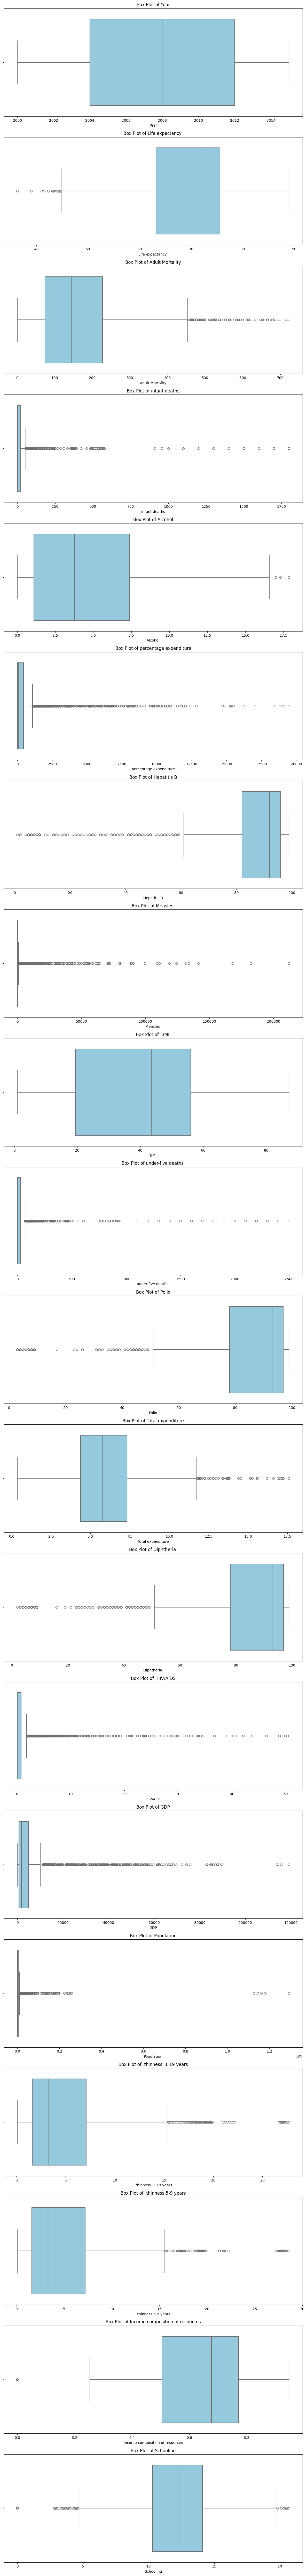

In [ ]:
# Get numerical columns
numerical_columns = df.select_dtypes(include=['number']).columns

# Create subplots for each numerical column
num_columns = len(numerical_columns)
fig, axes = plt.subplots(num_columns, 1, figsize=(12, num_columns * 5))

# Loop through each numerical column and plot its boxplot
for i, column in enumerate(numerical_columns):
    sns.boxplot(data=df, x=column, ax=axes[i], color='skyblue', linewidth=1.5)
    axes[i].set_title(f"Box Plot of {column}")

plt.tight_layout()
plt.show()

**Visualizing Data Distribution**

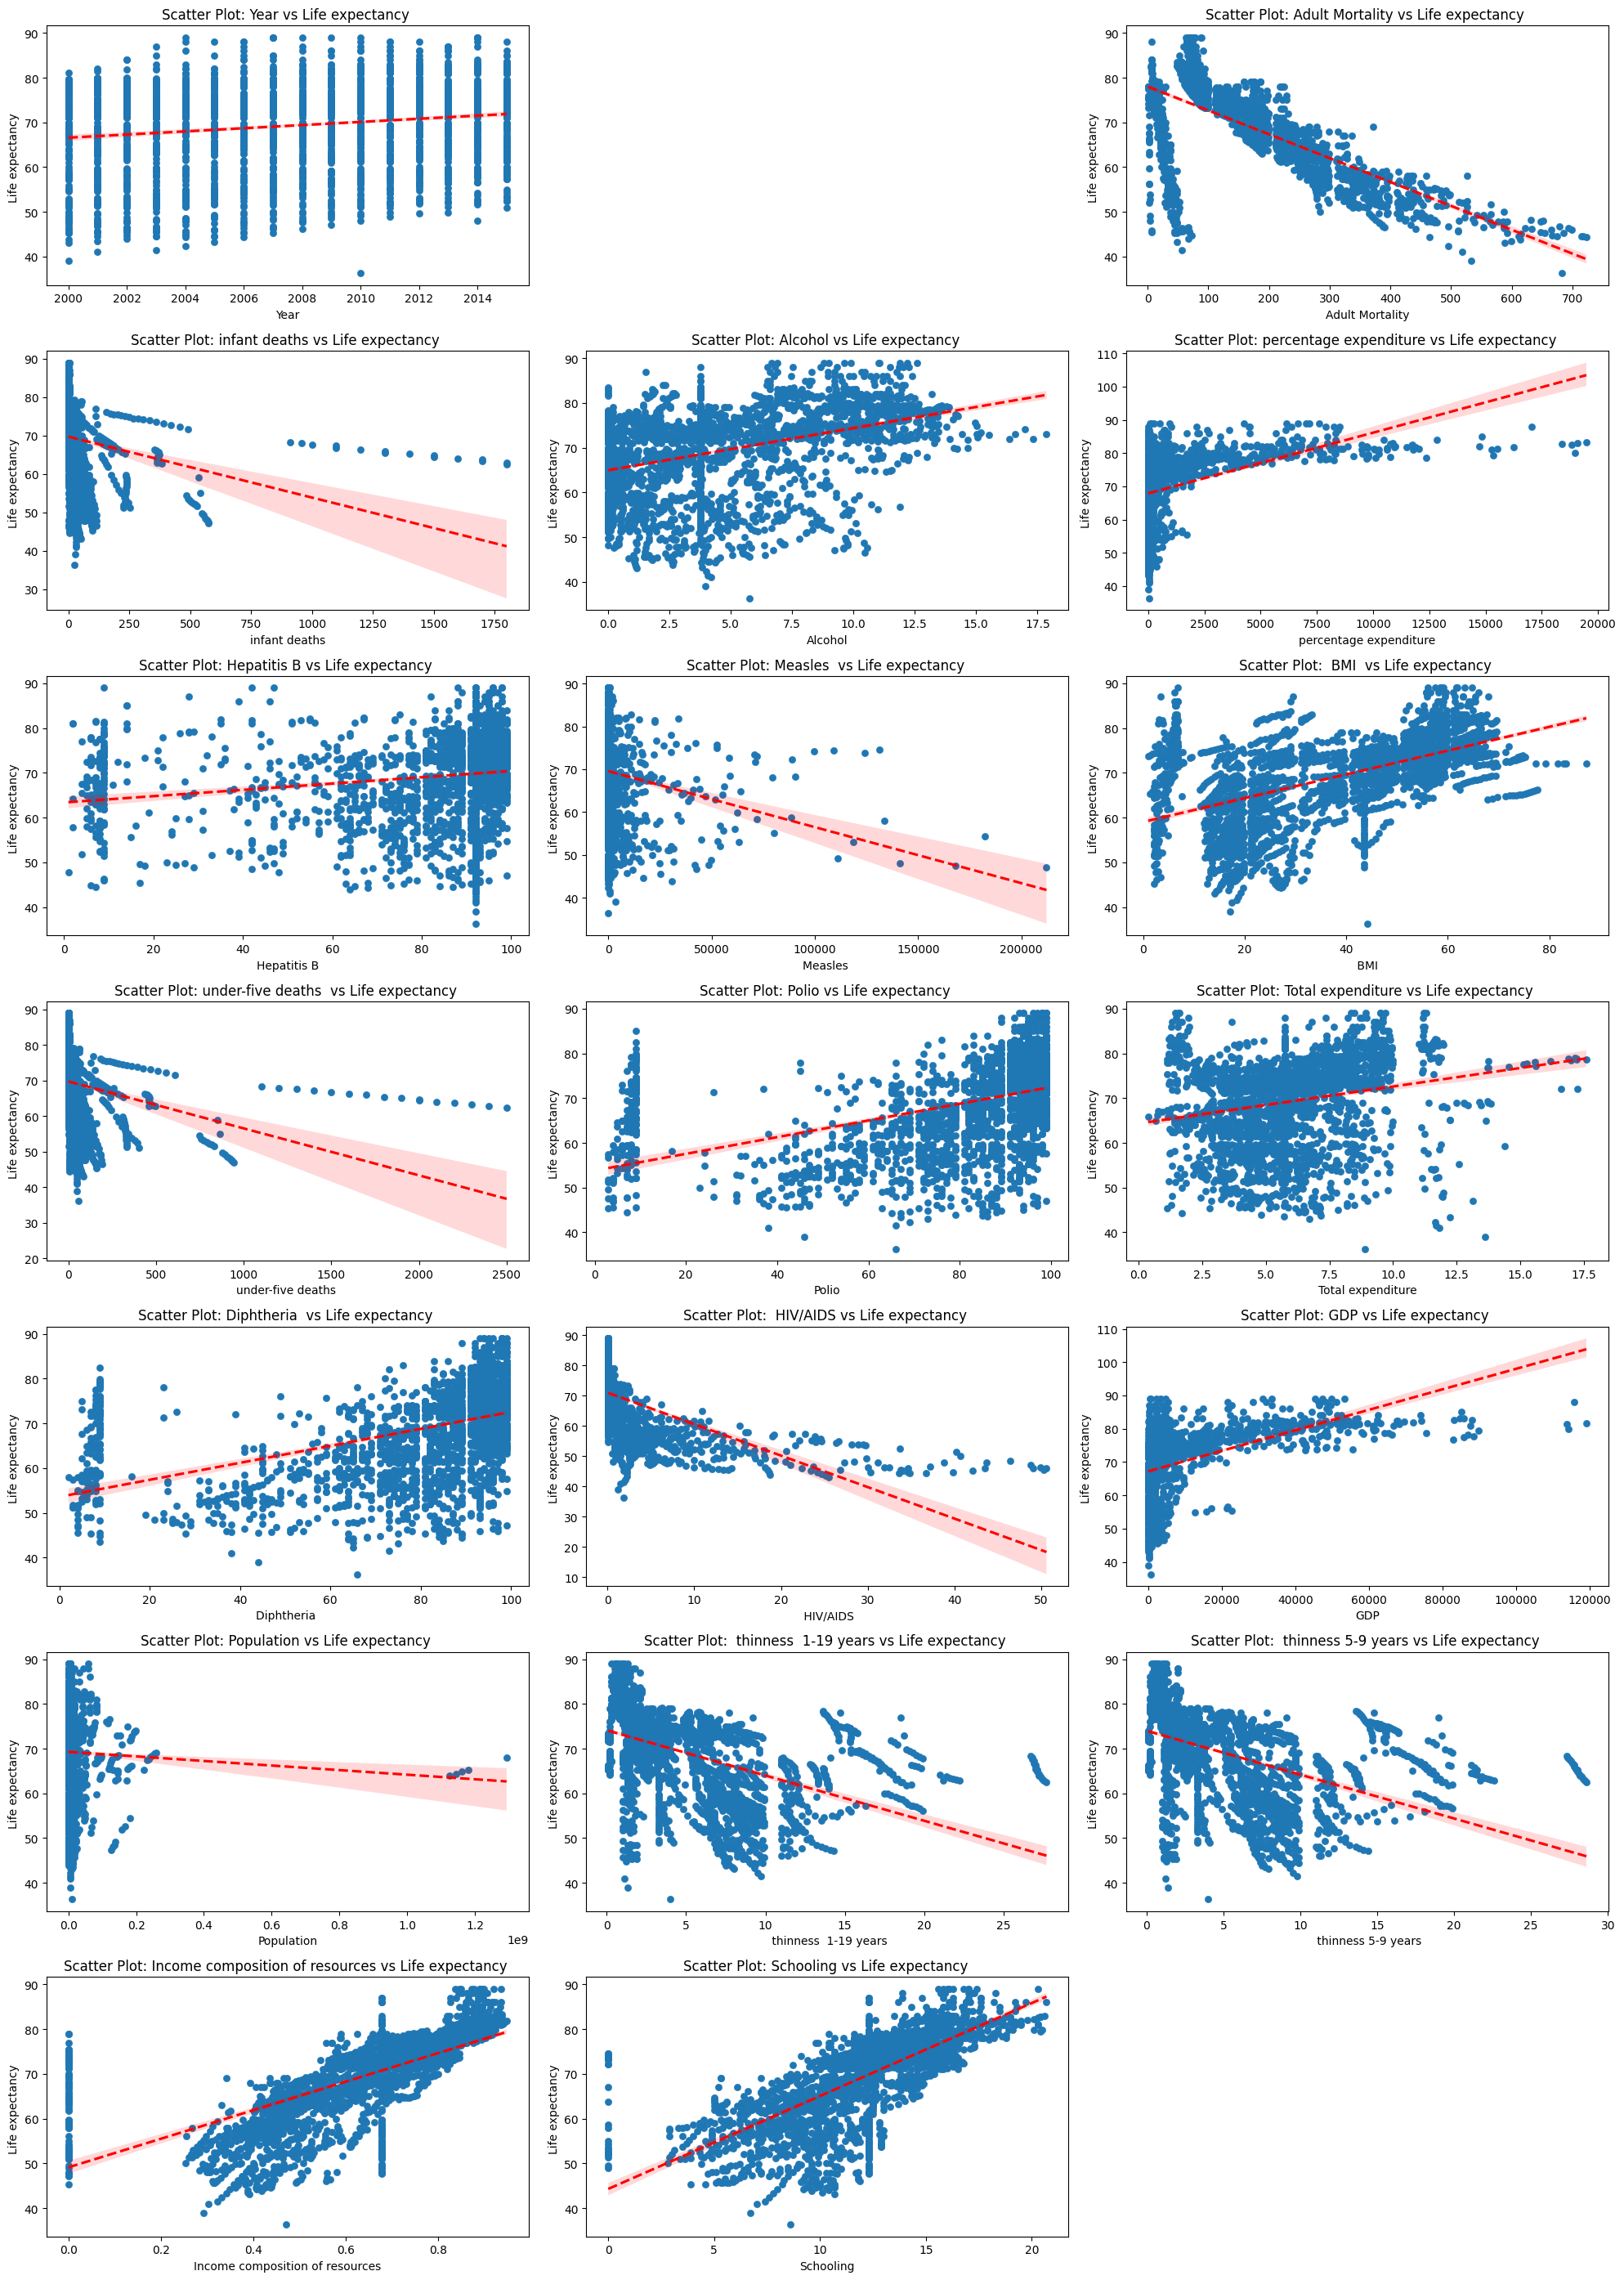

In [ ]:
numerical_columns = df.select_dtypes(include=np.number).columns

plt.figure(figsize=(20, 28))

for i, col in enumerate(numerical_columns):
    if col != 'Life expectancy ':
        plt.subplot(len(numerical_columns) // 3 + 1, 3, i + 1)
        sns.scatterplot(data=df, x=col, y='Life expectancy ')
        sns.regplot(data=df, x=col, y='Life expectancy ', scatter_kws={'s': 30}, line_kws={'color': 'red', 'linestyle': '--'})
        plt.title(f'Scatter Plot: {col} vs Life expectancy ')

plt.tight_layout()
plt.show()

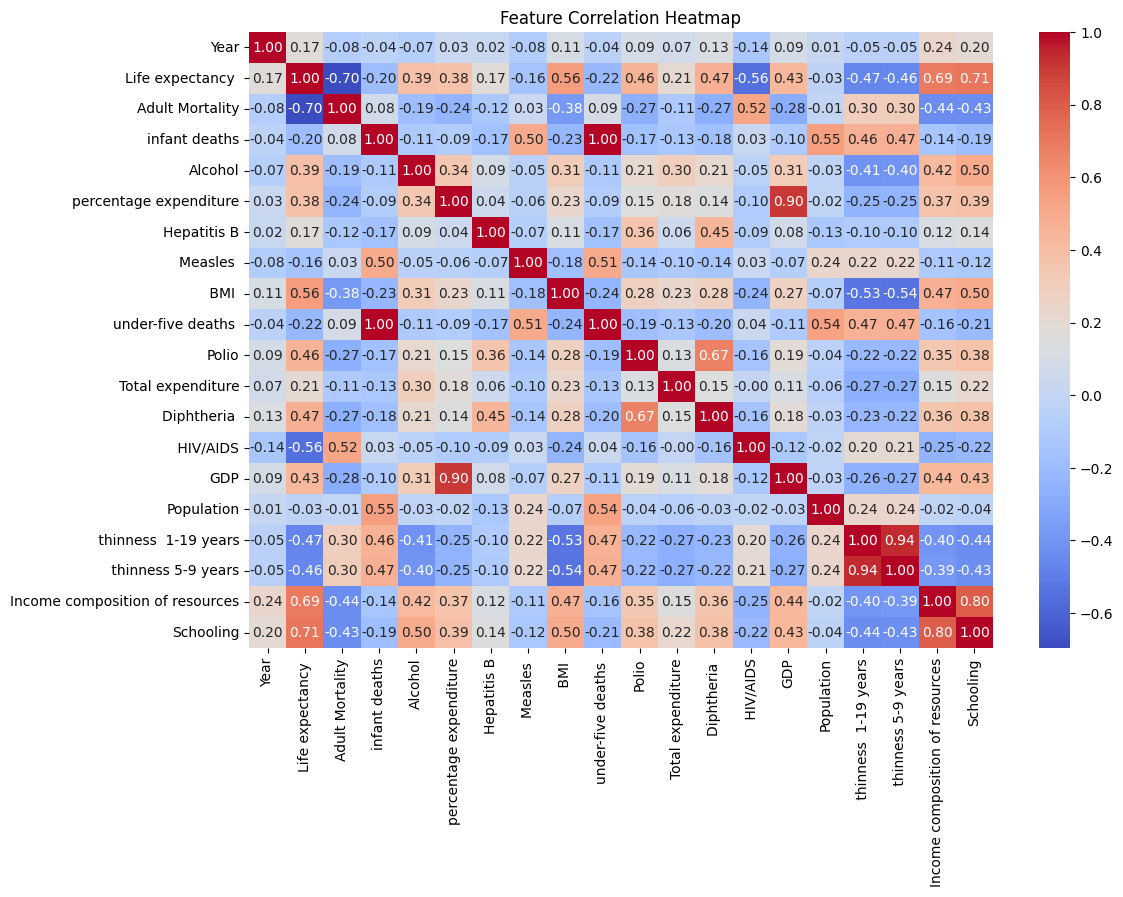

In [ ]:
# Drop non-numeric columns before correlation analysis
df_numeric = df.select_dtypes(include=['number'])

# Compute and visualize correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(df_numeric.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

In [ ]:
# Identify categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns
print("Categorical Columns:", categorical_columns)

# Convert categorical columns to numeric using one-hot encoding
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

# Ensure all columns are numeric
print(df.info())

# Now split and scale
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)


Categorical Columns: Index(['Country', 'Status'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Columns: 213 entries, Year to Status_Developing
dtypes: bool(193), float64(16), int64(4)
memory usage: 1012.9 KB
None


# Build Model from Scratch

**Implement Linear Regression from Scratch**

In [ ]:
# Model Training & Evaluation
def cost_function(X, Y, W):
    m = len(Y)
    loss = np.sum((X.dot(W)-Y)**2)
    J = loss /(2*m)


    return J

def gradient_descent(X, y, W, alpha, iterations):
    m = len(y)
    cost_history = []

    for i in range(iterations):
        y_pred = X.dot(W)

        error = y_pred - y

        gradient = (1 / m) * X.T.dot(error)

        W = W - alpha * gradient

        cost = cost_function(X, y, W)
        cost_history.append(cost)

    return W, cost_history

def rmse_test(Y, Y_pred):
  return np.sqrt(np.mean((Y - Y_pred) ** 2))


def r2_test(Y, Y_pred):
  ss_total = np.sum((Y - np.mean(Y)) ** 2)
  ss_residual = np.sum((Y - Y_pred) ** 2)
  return 1 - (ss_residual / ss_total)

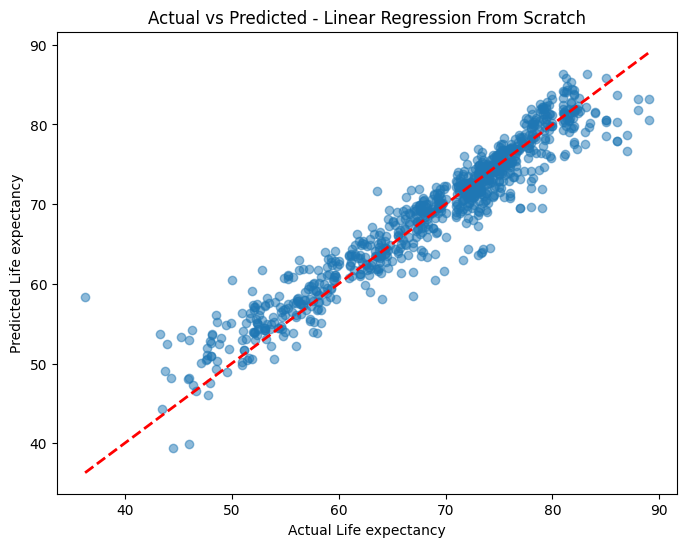

In [ ]:
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns
categorical_features = df.select_dtypes(include=['object']).columns

le = LabelEncoder()
df_encoded = df.copy()
for col in categorical_features:
    df_encoded[col] = le.fit_transform(df[col])

X = df_encoded.drop(['Life expectancy '], axis=1)
y = df_encoded['Life expectancy ']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale Features
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

# Add Bias Term
X_train_biased = np.c_[np.ones(X_train_scaled.shape[0]), X_train_scaled]
X_test_biased = np.c_[np.ones(X_test_scaled.shape[0]), X_test_scaled]

# Initialize Parameters
W = np.random.randn(X_train_biased.shape[1]) * 0.01

# Train Model
alpha = 0.0001
iterations = 10000
W_update, cost_history = gradient_descent(X_train_biased, y_train_scaled, W, alpha, iterations)

# Predictions
y_pred_train_scaled = X_train_biased.dot(W_update)
y_pred_train = scaler_y.inverse_transform(y_pred_train_scaled.reshape(-1, 1)).flatten()

y_pred_scaled = X_test_biased.dot(W_update)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

# Plot Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Life expectancy')
plt.ylabel('Predicted Life expectancy')
plt.title('Actual vs Predicted - Linear Regression From Scratch')
plt.show()

**Prediction**

In [ ]:
rmse_train_value = rmse_test(y_train, y_pred_train)
r2_train_value = r2_test(y_train, y_pred_train)

rmse_value = rmse_test(y_test, y_pred)
r2_value = r2_test(y_test, y_pred)

print("Train Results:")
print("RMSE:", rmse_train_value)
print("R-squared:", r2_train_value)

print("\nTest Results:")

print("RMSE:", rmse_value)
print("R-squared:", r2_value)

Train Results:
RMSE: 2.7149586503645335
R-squared: 0.9171472031542578

Test Results:
RMSE: 2.8446484326953487
R-squared: 0.9134531874400383


# Build Other Models

In [ ]:
# Split data, ensuring consistency across models
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features, ensuring consistency across models
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)


## Lasso Regression
lasso = Lasso(alpha=0.1)
lasso.fit(x_train, y_train)
y_pred = lasso.predict(x_test)
print("\nLasso Regression:")
print("MSE:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))

## Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_split=10, random_state=42)
rf_model.fit(x_train, y_train)
y_pred = rf_model.predict(x_test)
print("\nRandom Forest:")
print("MSE:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))


Lasso Regression:
MSE: 0.08995040843156996
R2 Score: 0.3470129545685279

Random Forest:
MSE: 0.004212250090783901
R2 Score: 0.9694215424992548


# Hyperparameter Tuning

**Lasso Regression**

In [ ]:

# Define the hyperparameter search space
lasso_param_dist = {
    'alpha': np.logspace(-4, 2, 50),  # Alpha values from 0.0001 to 100
    'max_iter': np.arange(500, 5001, 500)  # Iterations from 500 to 5000
}

# Create the Lasso model
lasso_model = Lasso(random_state=42)

# Perform RandomizedSearchCV
random_search_lasso = RandomizedSearchCV(
    estimator=lasso_model,
    param_distributions=lasso_param_dist,
    n_iter=50,  # Number of random searches
    cv=5,  # 5-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit the model
random_search_lasso.fit(x_train, y_train)

# Get the best parameters
print(f"Best Parameters for Lasso: {random_search_lasso.best_params_}")
print(f"Best cross-validation score: {random_search_lasso.best_score_}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters for Lasso: {'max_iter': 5000, 'alpha': 0.0001}
Best cross-validation score: 0.9999954057098339


In [ ]:
# Make predictions
y_pred = random_search_lasso.predict(x_test)

# Evaluate performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 5.505211607936317e-07
R-squared: 0.9999960035402562


**Random Forest**

In [ ]:
param_dist = {
    'n_estimators': np.arange(10, 201, 10),
    'max_features': ['sqrt', 'log2', None],
    'max_depth': np.arange(1, 21, 1),
    'min_samples_split': np.arange(2, 11, 1),
    'min_samples_leaf': np.arange(1, 11, 1),
    'bootstrap': [True, False],
}

rf_reg_model = RandomForestRegressor(random_state=42)

random_search_rf = RandomizedSearchCV(estimator=rf_reg_model,
                                   param_distributions=param_dist,
                                   n_iter=100,
                                   cv=5,
                                   verbose=2,
                                   random_state=42,
                                   n_jobs=-1)

random_search_rf.fit(x_train, y_train)

# Get the best parameters
print(f"Best Parameters: {random_search_rf.best_params_}")
print(f"Best cross-validation score: {random_search_rf.best_score_}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters: {'n_estimators': 150, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 16, 'bootstrap': True}
Best cross-validation score: 0.9732430723509425


In [ ]:
y_pred = random_search_rf.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 0.0020437415972939946
R-squared: 0.9851636383812792


# Feature Selection

**Lasso Feature Selection**

In [ ]:
# Feature Selection
sfm = SelectFromModel(lasso)
sfm.fit(x_train, y_train)
x_train_selected = sfm.transform(x_train)
x_test_selected = sfm.transform(x_test)

# Display selected features
selected_features = df.columns[:-1][sfm.get_support()]
print("\nSelected Features:", list(selected_features))


Selected Features: ['Life expectancy ', 'Alcohol', 'percentage expenditure', 'GDP', 'Schooling']


**Random Forest Feature Selection**

In [ ]:
ran_for = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_split=10, random_state=42)

# Fit the model
ran_for.fit(x_train, y_train)

# Select features based on coefficients
sfm = SelectFromModel(ran_for, threshold="mean", max_features=5)
sfm.fit(x_train, y_train)

x_train_selected = sfm.transform(x_train)
x_test_selected = sfm.transform(x_test)

# Display selected features
selected_features = df.columns[:-1][sfm.get_support()]
print("\nSelected Features:", list(selected_features))


Selected Features: ['Life expectancy ', 'Alcohol', ' thinness  1-19 years', ' thinness 5-9 years', 'Income composition of resources']


# Final Model Training

In [ ]:
final_rf_model = RandomForestRegressor(n_estimators= 150, min_samples_split= 4, min_samples_leaf= 1, max_features= None, max_depth= 16, bootstrap= True)
final_rf_model.fit(x_train_selected, y_train)

# Predictions on test data
final_y_pred = final_rf_model.predict(x_test_selected)

# Model Evaluation
print("\nFinal Model: Random Forest Regressor on Selected Features")
print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, final_y_pred))
print("Mean Squared Error (MSE):", mean_squared_error(y_test, final_y_pred))
print("Root Mean Squared Error (RMSE):", np.sqrt(mean_squared_error(y_test, final_y_pred)))
print("R2 Score:", r2_score(y_test, final_y_pred))


Final Model: Random Forest Regressor on Selected Features
Mean Absolute Error (MAE): 0.11757640245289983
Mean Squared Error (MSE): 0.06678236593617955
Root Mean Squared Error (RMSE): 0.25842284329404697
R2 Score: 0.515199312821751
